In [1]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import gaussian_process.regression as gpr
from gaussian_process.kernels import RBF

### 1D case

In [2]:
key = random.PRNGKey(0)

def func(x,noise=0.0):
    return jnp.sin(x) + noise*random.normal(key,x.shape)

def grad_func(x,noise=0.0):
    return jnp.cos(x) + noise*random.normal(key,x.shape)

In [3]:
bounds = jnp.array([0.0, 2*jnp.pi])

noise = 0.1

length_scale = 1.0

num_datapoints = 9
datagrid = jnp.linspace(*bounds,num_datapoints)
data_values = func(datagrid,noise)
num_derivpoints = (9,)
derivative_grid = jnp.linspace(*bounds,num_derivpoints[0])
derivative_values = grad_func(derivative_grid,noise)
data_split = (num_datapoints, ) + num_derivpoints

X_data = jnp.concatenate((datagrid,derivative_grid)).reshape(-1,1)
Y_data = jnp.concatenate((data_values,derivative_values)).reshape(-1,1)

num_referencepoints = 9
referencegrid = jnp.linspace(*bounds,num_referencepoints).reshape(-1,1)

num_gridpoints = 101
grid = jnp.linspace(*bounds,num_gridpoints)

kernel = RBF()
kernel_params = (length_scale,)

[-11.909783 -12.405271 -12.859421 -13.274721 -13.648115 -13.975094
 -14.252473 -14.479173 -14.65542  -14.781668 -14.857991 -14.884047
 -14.859581 -14.785099 -14.662426 -14.494808 -14.286304 -14.04106
 -13.762476 -13.452801]
[ 4.0903134   3.166572    2.257834    1.4258928   0.70684767  0.10218191
 -0.39386892 -0.79423237 -1.1291122  -1.3942094  -1.6243229  -1.8038325
 -1.940175   -2.0561948  -2.1321778  -2.1843123  -2.2132373  -2.2285929
 -2.2185636  -2.2126675 ]


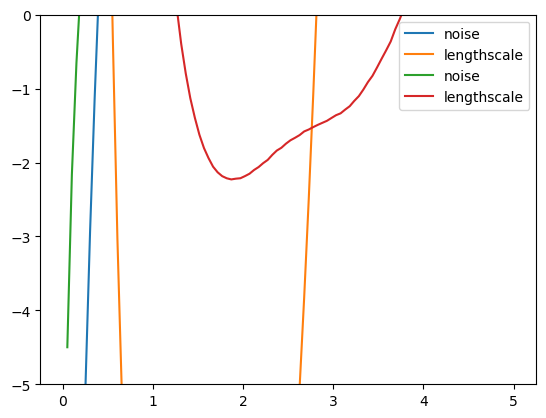

In [4]:
model = gpr.ExactGPR(kernel,data_split,kernel_params,noise=noise)
model.train(X_data,Y_data)
(means_full, stds_full) = model.eval(grid.reshape(-1,1),True)
means_full = means_full.reshape(-1)
stds_full = stds_full.reshape(-1)

model = gpr.ApproximateGPR(kernel,data_split,referencegrid,kernel_params,noise=noise)
model.train(X_data,Y_data)
(means_full, stds_full) = model.eval(grid.reshape(-1,1),True)
means_full = means_full.reshape(-1)
stds_full = stds_full.reshape(-1)

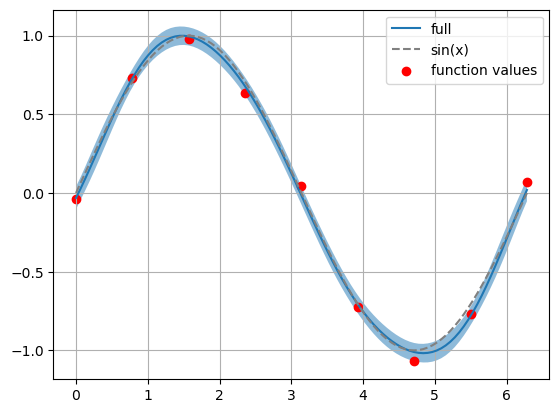

In [5]:
plt.plot(grid,means_full,label="full")
plt.fill_between(grid,means_full-stds_full,means_full+stds_full,alpha=0.5)
plt.plot(grid,func(grid),color="grey",ls="--",label="sin(x)")
plt.scatter(datagrid,data_values,color="r",label="function values")
plt.grid()
plt.legend()

In [6]:
from jax.scipy.stats import gamma, expon

(0.0, 20.0)

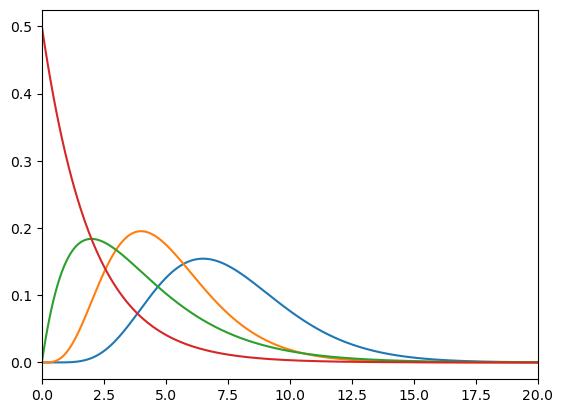

In [7]:
grid = jnp.linspace(0.0, 20.0, 500)
y_1 = gamma.pdf(grid, 7.5, 0.0, 1.0)
y_2 = gamma.pdf(grid, 5.0, 0.0, 1.0)
y_3 = gamma.pdf(grid, 2.0, 0.0, 2.0)
y_4 = gamma.pdf(grid, 1.0, 0.0, 2.0)
y_5 = gamma.pdf(grid, 2.0, 0.0, 0.1)

plt.plot(grid, y_1)
plt.plot(grid, y_2)
plt.plot(grid, y_3)
plt.plot(grid, y_4)
# plt.plot(grid, y_5)
plt.xlim(0,20.0)

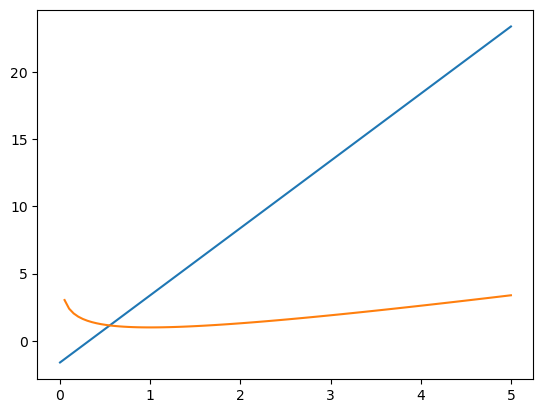

In [8]:
grid = jnp.linspace(0.0, 5.0, 100)
y_1 = -expon.logpdf(grid, 0.0, 0.2)
y_2 = -gamma.logpdf(grid, 2.0)

plt.plot(grid, y_1)
plt.plot(grid, y_2)

In [26]:
def get_next_param():
    grid = jnp.linspace(1e-4, 5.0, 40)

    for i in grid:
        for j in grid:
            for k in grid:
                yield jnp.array([i, j, k])

def f(cur, params):
    temp = jnp.sum(params)
    return cur+temp, None


In [27]:
from jax.lax import scan

In [28]:
scan(f, 0, get_next_param)

ValueError: scan got value with no leading axis to scan over: <function get_next_param at 0x7f21b1943550>.